# Ising model with Monte Carlo simulation
##The Metropolis algorithm

In [1]:
import sys
!{sys.executable} -m jupyter nbextension install --user --py widgetsnbextension
!{sys.executable} -m  jupyter nbextension enable widgetsnbextension --user --py

Installing c:\users\miky2\appdata\local\programs\python\python39\lib\site-packages\widgetsnbextension\static -> jupyter-js-widgets
Up to date: C:\Users\miky2\AppData\Roaming\jupyter\nbextensions\jupyter-js-widgets\extension.js
Up to date: C:\Users\miky2\AppData\Roaming\jupyter\nbextensions\jupyter-js-widgets\extension.js.map
- Validating: ok

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --user --py
    
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import numpy as np

def random_spins(N, M):
    return np.random.choice([-1, 1], size = (N, M))

random_spins(10, 10)

array([[ 1,  1,  1, -1, -1, -1, -1,  1, -1,  1],
       [-1, -1,  1,  1, -1, -1,  1,  1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  1, -1, -1,  1],
       [ 1,  1,  1,  1, -1, -1, -1,  1,  1,  1],
       [-1, -1,  1, -1, -1,  1, -1,  1, -1, -1],
       [ 1,  1,  1, -1, -1,  1, -1,  1,  1,  1],
       [ 1, -1,  1,  1, -1, -1, -1, -1,  1, -1],
       [ 1, -1, -1, -1,  1,  1, -1,  1, -1,  1],
       [ 1, -1, -1,  1, -1,  1, -1, -1, -1, -1],
       [ 1, -1,  1,  1,  1, -1,  1,  1,  1,  1]])

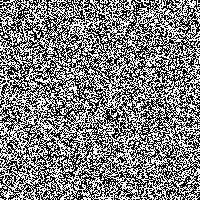

In [3]:
from PIL import Image 

def display_spins(field):
    return Image.fromarray(np.uint8((field+1)*0.5*255))

display_spins(random_spins(200, 200))

In [23]:
def ising_step(field, beta=0.4):
    N,M=field.shape
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    ising_update(field, n, m, beta)
    return field

def ising_update(field, n, m, beta):
    N,M = field.shape
    total = 0
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i%N, j%M]
    dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif np.exp(-dE * beta) > np.random.rand():
        field[n, m] *= -1

Wall time: 260 ms


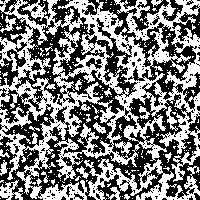

In [5]:
%time display_spins(ising_step(random_spins(200, 200)))


In [6]:
from ipywidgets import interact


def animate(images):
    def mostra(frame=(0,len(images)-1)):
        return display_spins(images[frame])
    return interact(mostra)

In [24]:
images = [random_spins(200, 200)]
for i in range(50):
    images.append(ising_step(images[-1].copy()))
animate(images)

interactive(children=(IntSlider(value=25, description='frame', max=50), Output()), _dom_classes=('widget-inter…

<function __main__.animate.<locals>.mostra(frame=(0, 50))>

Since is very slow i try to improve the speed

In [26]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [35]:
%%cython

import numpy as np
cimport numpy as np

from libc.math cimport exp
from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX


def cy_ising_step(long[:, :] field, float beta=0.4):
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int n_offset, m_offset, n, m
    for n_offset in range(2):
        for m_offset in range(2):
            for n in range(n_offset, N, 2):
                for m in range(m_offset, M, 2):
                    cy_ising_update(field, n, m, beta)
    return np.array(field)


cdef cy_ising_update(long[:, :] field, int n, int m, float beta):
    cdef int total = 0
    cdef int N = field.shape[0]
    cdef int M = field.shape[1]
    cdef int i, j
    for i in range(n-1, n+2):
        for j in range(m-1, m+2):
            if i == n and j == m:
                continue
            total += field[i % N, j % M]
    cdef float dE = 2 * field[n, m] * total
    if dE <= 0:
        field[n, m] *= -1
    elif exp(-dE * beta) * RAND_MAX > rand():
        field[n, m] *= -1

In [36]:
field = random_spins(200,200)
%timeit ising_step(field)
%timeit cy_ising_step(field)

374 ms ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.49 ms ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
images = [random_spins(500, 500)]
for i in range(1000):
    images.append(cy_ising_step(images[-1].copy(), beta=0.4))
animate(images)

interactive(children=(IntSlider(value=500, description='frame', max=1000), Output()), _dom_classes=('widget-in…

<function __main__.animate.<locals>.mostra(frame=(0, 1000))>